## Import libraries ##

In [37]:
import tensorflow as tf
import cv2
import numpy as np
import os
import shutil
from random import shuffle
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.python.saved_model import tag_constants

## Should reset tensorflow graph ## 

In [20]:
tf.reset_default_graph()

## Init parameters ##

In [205]:
FACES_DIR = '../data/HvN/faces_full'
FACES_DIR_TEST = '../data/face_croped'
MODEL_NAME = '../tmp/modelFaceNN'
IMG_SIZE = 100
LR = 1e-4
FRACTION = 8/10
N_NODES_HL1 = 500
N_NODES_HL2 = 300
N_NODES_HL3 = 100
N_CLASSES = 2
TRAINING_EPOCHS = 500
BATCH_SIZE = 32

## Process data##
#### Apply one-hot for labels ####

In [206]:
def process_file(file_name):
    label = file_name[-5:][:1]
    if label == 'M':
        return [1,0]
    elif label == 'F':
        return [0,1]

In [207]:
def process_folder(input_folder_path):
    data = []
    for img in tqdm(os.listdir(input_folder_path)):
        label = process_file(img)
        path = os.path.join(input_folder_path, img)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        data.append([np.array(img, dtype=np.float32), np.array(label, dtype=np.float32)])
    shuffle(data)
    return data

In [208]:
def process_test_folder(input_folder_path):
    data = []
    for img in tqdm(os.listdir(input_folder_path)):
        img_name = img.split('.')[0]
        path = os.path.join(input_folder_path, img)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        data.append([np.array(img, dtype=np.float32), img_name])
    shuffle(data)
    return data

In [209]:
data = process_folder(FACES_DIR)
predict_data = process_test_folder(FACES_DIR_TEST)

100%|████████████████████████████████████████████████████████████████████████████| 2411/2411 [00:01<00:00, 2063.37it/s]


## Define Neural Network model ##


In [210]:
def neural_network_model(data):
    hidden_1_layer = {'weights':tf.Variable(tf.random_normal([IMG_SIZE*IMG_SIZE, N_NODES_HL1], dtype=np.float32), name="w1"),
                      'biases':tf.Variable(tf.random_normal([N_NODES_HL1], dtype=np.float32), name="b1")}

    hidden_2_layer = {'weights':tf.Variable(tf.random_normal([N_NODES_HL1, N_NODES_HL2], dtype=np.float32), name="w2"),
                      'biases':tf.Variable(tf.random_normal([N_NODES_HL2], dtype=np.float32), name="b2")}

    hidden_3_layer = {'weights':tf.Variable(tf.random_normal([N_NODES_HL2, N_NODES_HL3], dtype=np.float32), name="w3"),
                      'biases':tf.Variable(tf.random_normal([N_NODES_HL3], dtype=np.float32), name="b3")}

    output_layer = {'weights':tf.Variable(tf.random_normal([N_NODES_HL3, N_CLASSES], dtype=np.float32), name="w"),
                    'biases':tf.Variable(tf.random_normal([N_CLASSES], dtype=np.float32), name="b"),}


    f1 = tf.add(tf.matmul(data, hidden_1_layer['weights']), hidden_1_layer['biases'])
    a1 = tf.nn.relu(f1)

    f2 = tf.add(tf.matmul(a1, hidden_2_layer['weights']), hidden_2_layer['biases'])
    a2 = tf.nn.relu(f2)

    f3 = tf.add(tf.matmul(a2, hidden_3_layer['weights']), hidden_3_layer['biases'])
    a3 = tf.nn.relu(f3)

    output = tf.add(tf.matmul(a3, output_layer['weights']), output_layer['biases'])

    return output

In [211]:
def predict_neural_network_model(data,  w, b, w1, b1, w2, b2, w3, b3):
    hidden_1_layer = {'weights': w1,
                      'biases': b1}

    hidden_2_layer = {'weights':w2,
                      'biases':b2}

    hidden_3_layer = {'weights':w3,
                      'biases':b3}

    output_layer = {'weights':w,
                    'biases':b}


    f1 = tf.add(tf.matmul(data, hidden_1_layer['weights']), hidden_1_layer['biases'])
    a1 = tf.nn.relu(f1)

    f2 = tf.add(tf.matmul(a1, hidden_2_layer['weights']), hidden_2_layer['biases'])
    a2 = tf.nn.relu(f2)

    f3 = tf.add(tf.matmul(a2, hidden_3_layer['weights']), hidden_3_layer['biases'])
    a3 = tf.nn.relu(f3)

    output = tf.add(tf.matmul(a3, output_layer['weights']), output_layer['biases'])

    return output

In [212]:
def train_neural_network(x, y, x_train, y_train, x_test, y_test, display_step = 1):
    nn_output = neural_network_model(x)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=nn_output, labels=y))
    optimizer = tf.train.AdamOptimizer(LR).minimize(cost)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        #Fit all training data
        avg_cost = 0
        for epoch in range(TRAINING_EPOCHS):
            _, c = sess.run([optimizer, cost], feed_dict={x: x_train, y: y_train})
            avg_cost += c/TRAINING_EPOCHS
            if epoch % display_step == 0:
                print('Epoch', epoch + 1, 'loss:', avg_cost)

        correct = tf.equal(tf.argmax(nn_output, 1), tf.argmax(y, 1))

        accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
        print('Accuracy:', accuracy.eval({x:x_test, y:y_test}))

        # Saving
        inputs = {
            "features": x,
            "labels": y,
        }
        
        outputs = {"prediction": nn_output}
        
        if os.path.exists(MODEL_NAME):
            shutil.rmtree(MODEL_NAME)
        
        tf.saved_model.simple_save(
            sess, MODEL_NAME, inputs, outputs
        )

In [213]:
def train_nn(x, y, x_train, y_train, x_test, y_test, display_step = 1):
    nn_output = neural_network_model(x)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=nn_output, labels=y))
    optimizer = tf.train.AdamOptimizer(learning_rate=LR).minimize(cost)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch in range(TRAINING_EPOCHS):
            total_batch = int(len(x_train) / BATCH_SIZE)
            x_batches = np.array_split(x_train, total_batch)
            y_batches = np.array_split(y_train, total_batch)
            avg_cost = 0
            for i in range(total_batch):
                batch_x, batch_y = x_batches[i], y_batches[i]
                _, c = sess.run([optimizer, cost], feed_dict={x: batch_x, y: batch_y})
                avg_cost += c/TRAINING_EPOCHS
                
            if epoch % display_step == 0:
                print('Epoch', epoch + 1, 'loss:', avg_cost)
                
        correct = tf.equal(tf.argmax(nn_output, 1), tf.argmax(y, 1))

        accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
        print('Accuracy:', accuracy.eval({x:x_test, y:y_test}))
        
        # Saving
        inputs = {
            "features": x,
            "labels": y,
        }
        
        outputs = {"prediction": nn_output}
        
        if os.path.exists(MODEL_NAME):
            shutil.rmtree(MODEL_NAME)
        
        tf.saved_model.simple_save(
            sess, MODEL_NAME, inputs, outputs
        )

In [214]:
train = data[:int(len(data)*FRACTION)]
test = data[int(len(data)*FRACTION):]

In [215]:
def prepare_data(train, test=None):
    X=[]
    Y=[]
    test_x=[]
    test_y=[]
    for x in train:
        X.append(x[0])
        Y.append(x[1])
        
    X = np.array(X).reshape(-1, IMG_SIZE*IMG_SIZE)    
    Y = np.array(Y).reshape(-1, 2)  
    for x in test:
        test_x.append(x[0])
        test_y.append(x[1])
    
    test_x = np.array(test_x).reshape(-1, IMG_SIZE * IMG_SIZE)   
    test_y = np.array(test_y).reshape(-1, 2) 
    
    return X, Y, test_x, test_y

In [216]:
x_train, y_train, x_test, y_test = prepare_data(train, test)

In [217]:
print(x_train.shape)
print(y_train.shape)

(741, 10000)
(741, 2)


In [218]:
x = tf.placeholder('float', [None, IMG_SIZE*IMG_SIZE], name='features_placeholder')
y = tf.placeholder('float', [None, 2], name='labels_placeholder')

In [204]:
train_nn(x,y, x_train, y_train, x_test, y_test, display_step=1)

Epoch 1 loss: 7746447.975
Epoch 2 loss: 2005142.33828125
Epoch 3 loss: 1282964.5390624998
Epoch 4 loss: 978634.20234375
Epoch 5 loss: 840588.8703124999
Epoch 6 loss: 685916.179296875
Epoch 7 loss: 581873.50078125
Epoch 8 loss: 503826.501171875
Epoch 9 loss: 437930.3221191406
Epoch 10 loss: 395754.3880859375
Accuracy: 0.75268817
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ../tmp/modelFaceNN\saved_model.pb


In [219]:
train_neural_network(x,y, x_train, y_train, x_test, y_test, display_step=50)

Epoch 1 loss: 3656.44225
Epoch 51 loss: 86118.629625
Epoch 101 loss: 110771.26112499996
Epoch 151 loss: 118894.82484374997
Epoch 201 loss: 121472.30879492177
Epoch 251 loss: 121955.85664379879
Epoch 301 loss: 121983.8791357927
Epoch 351 loss: 121983.88891042181
Epoch 401 loss: 121983.88891042181
Epoch 451 loss: 121983.88891042181
Accuracy: 0.7688172
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ../tmp/modelFaceNN\saved_model.pb


In [152]:
def prepare_predict_data(predict):
    X=[]
    Y=[]
    for x in predict:
        X.append(x[0])
        Y.append(x[1])
        
    X = np.array(X).reshape(-1, IMG_SIZE*IMG_SIZE)    
    Y = np.array(Y).reshape(-1, 1)    
    
    return X, Y

In [153]:
def show_image(x_array):
    img_arr = np.reshape(x_array, (IMG_SIZE, IMG_SIZE))
    plt.imshow(img_arr, cmap="gray")

In [154]:
def predict_saved_model(predict_data):
    graph2 = tf.Graph()
    with graph2.as_default():
        with tf.Session() as sess:
            print('\nRestoring...')
            tf.saved_model.loader.load(
                    sess,
                    [tag_constants.SERVING],
                    MODEL_NAME
                )
            print('Ok')

            w = graph2.get_tensor_by_name('w:0')
            b = graph2.get_tensor_by_name('b:0')
            w1 = graph2.get_tensor_by_name('w1:0')
            b1 = graph2.get_tensor_by_name('b1:0')
            w2 = graph2.get_tensor_by_name('w2:0')
            b2 = graph2.get_tensor_by_name('b2:0')
            w3 = graph2.get_tensor_by_name('w3:0')
            b3 = graph2.get_tensor_by_name('b3:0')

            orimg = predict_data[10]
            show_image(orimg)
            img = orimg.reshape(1,IMG_SIZE*IMG_SIZE);
            result = predict_neural_network_model(img, w=w, b=b, w1=w1, b1=b1, w2=w2, b2=b2, w3=w3, b3=b3)
            label = sess.run(result)
            print(label)
            if np.argmax(label) == 1:
                str_label = 'F' #[0, 1]
            else:
                str_label = 'M' #[1, 0]
            
            print(str_label)


Restoring...
INFO:tensorflow:Restoring parameters from ../tmp/modelFaceNN\variables\variables
Ok
[[-3176009. -7268777.]]
M


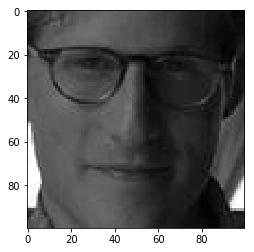

In [155]:
X_predict, Y_predict = prepare_predict_data(predict_data)

predict_saved_model(X_predict)